In [1]:
import pathlib
import pickle

import genjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import trimesh
from genjax.incremental import tree_diff_no_change
from jax.scipy.spatial.transform import Rotation
from PIL import Image, ImageDraw

import bayes3d as b
import bayes3d.scene_graph as scene_graph
import bayes3d.utils as bu

# A gentle introduction to GenJAX with Bayes3D

This notebook is an introduction to the world of probabilistic programming, specifically, the [Gen](https://github.com/opengen) flavor of programming pioneered by the [MIT Probabilistic Computing Laboratory](http://probcomp.csail.mit.edu). Gen provides a "rational engine" which can be used to quickly evaluate _proposals_ about the state of a system and then to guide the search toward ever more probable explanations. Bayes3D is a system designed to provide a GPU-accelerated method of this evaluation step in the context of machine vision, and GenJAX provides GPU acceleration for the nongraphic update part.

We'll begin this investigation with an ordinary coffee cup. We'll choose a position and orientation of the cup, and keep that information to ourselves. We will then inquire whether the machine can tell where the cup is just by looking at it.

## Some preliminaries

We begin by loading the cup model. Bayes3D has its own mesh loader, so we will initialize it with some camera parameters and then load the cup model (#13 in the [BOP collection](https://bop.felk.cvut.cz/datasets/) of test models).

In [2]:
asset_path = pathlib.Path(bu.get_assets_dir())
bop_model = lambda k: asset_path / f"bop/ycbv/models/obj_{k+1:06}.ply"
cup = trimesh.load(bop_model(13))
cup = cup.vertices * 1e-3

Here's a visualization of the vertex cloud of the cup model:

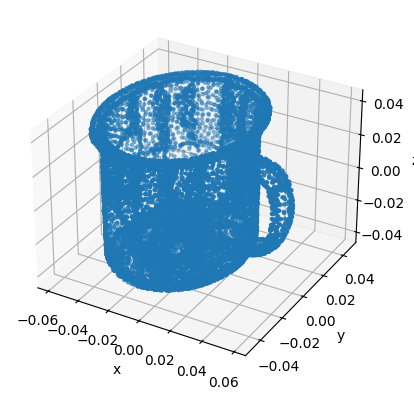

In [3]:
def viz():
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(cup[:, 0], cup[:, 1], cup[:, 2], marker=".")
    ax.set_xlabel("x")
    ax.set_ylabel("y"), ax.set_zlabel("z")


viz()

## The Pose Matrix

Now that we have an object, we'd like to situate it in space. You could imaging moving the cup in space to a some location in a room, and then rotating it. The position and orientation of an object is called its _pose_. 

The vertices of the cup model are arranged in the form of a two dimensional array: one row for each point, and 3 columns for x, y, and z. Suppose we want to rotate the cup 180º, so that the handle will appear on the right instead of the left. Looking at the plot, we can see that the cup is sitting on the $xy$ plane, with the $z$ axis going up through the center of the cup. So we want a rotation around the Z axis. Such a rotation can be represented by a _rotation matrix_:  

In [4]:
M = Rotation.from_euler("z", jnp.array([180]), True).as_matrix()
M

Array([[-1.000000e+00,  8.742278e-08,  0.000000e+00],
       [-8.742278e-08, -1.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]], dtype=float32)

Our task now is to multiply each row of the object by this matrix to accomplish the rotation of the entire body. The rotation matrix is 3x3; the vertices are Nx3. We can transpose the points into a 3xN matrix; then the standard matrix product will give is a 3xN result: (3x3 @ 3xN -> 3xN). This is transposed from what he had initially. (We could transpose it back, but we find that this form is convenient since `ax.scatter` wants to be called with individual vectors of $x, y$ and $z$ coordinates, and now we have exactly these in the three rows of our result). Let's write a function to put this together.

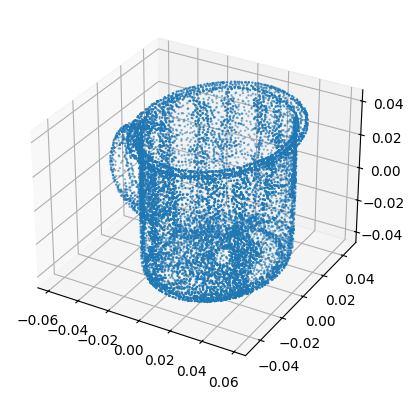

In [5]:
def viz_model(ax, model, M=jnp.eye(3)):
    Mv = M @ model.T
    ax.scatter(Mv[0], Mv[1], Mv[2], marker="o", s=(72.0 / fig.dpi) ** 2)


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
viz_model(ax, cup, M)

To change the size of the cup, we can _scale_ it. This just means multiplying each of the coordinates by a scaling constant: $>1$ to expand it and $<1$ to shrink it. It turns out a diagonal matrix will have this effect. (We could operate directly on the points; we could even multiply the whole vertices array by the constant efficiently using [brodcasting arithmetic](https://numpy.org/doc/stable/user/basics.broadcasting.html), but we prefer to use a diagonal matrix because it _composes_ (via matrix multiplication) with the other transformations we will make, so at the end, we will have one matrix that does the whole job. `Eye` is the numpy name for the identity matrix, which we might call the "unit scale matrix" in this application. If we multiply it by M, we will find that cup is rotated and scaled in one step:

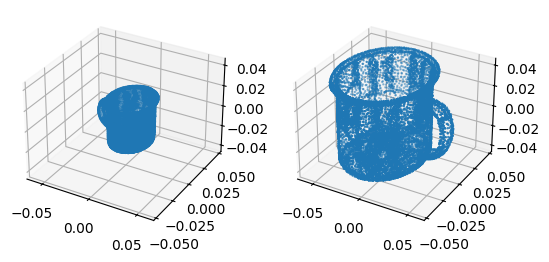

In [6]:
S = jnp.eye(3) * 0.5
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1, projection="3d")
ax1 = fig.add_subplot(1, 2, 2, projection="3d", sharex=ax0, sharey=ax0, sharez=ax0)
viz_model(ax0, cup, S @ M)
viz_model(ax1, cup)

The last piece of the puzzle is translation: moving the whole cup to another location, away from the origin. We can't use a 3x3 matrix for that, since translation is not _linear_ in the sense we use that term in linear algebra (for us, a linear transformation must carry the zero vector to the zero vector). We fix this by adding a dummy coordinate to our point vectors so that our transformation matrix becomes a 4x4 matrix. This gives us the freedom to encode a rotation, scaling, and translation all in the same matrix. (We could also do shear and reflection, but since those transformations aren't "physical" we won't worry about them in this notebook).

The 4x4 matrix is constructed this way. The rotation/scaling part of the matrix is in the upper-left 3x3 submatrix. The destination we want to translate to is in the right hand column (first three entries), and the bottom row is always [0,0,0,1]. A quick check shows, for example, that we can add 2 to the x and y coordinates, leaving everything else alone, like this: 

In [7]:
T = jnp.array([[1, 0, 0, 2], [0, 1, 0, 2], [0, 0, 1, 0], [0, 0, 0, 1]])
T @ jnp.array([1, 2, 3, 1])

Array([3, 4, 3, 1], dtype=int32)

Notice the "translation" vector is vertically in the rightmost column, and the "identity transformation" is in the 3x3 submatrix in the upper left. Let's write a function that will couple a rotation/scale matrix and translation vector into this form:

In [8]:
def make_pose(M, T):
    return jnp.block([[M, T.reshape((3, 1))], [jnp.zeros((1, 3)), jnp.ones((1, 1))]])

In [9]:
make_pose(jnp.eye(3), jnp.array([1, 2, 3]))

Array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 3.],
       [0., 0., 0., 1.]], dtype=float32)

We will take this opportunity to update our cup model to convert add the fourth dummy $1$ coordinate to each point:

In [10]:
cup4 = jnp.insert(cup, 3, 1.0, 1)

# Creating Poses with a Generative Function

Now back to the question of pose estimation using Bayes3D. In the Gen paradigm, we begin with a [generative function]() which can be _sampled_ to produce objects from a prior distribution which we represents what we know about what the ground truth could be. There are six degrees of freedom in a pose: it takes three coordinates for the translation part. Describing rotations can be done in many ways (such as an angle about an axis or Euler angles). 

Our generative function will accept arguments for position and Euler angles of rotation as generative functions themselves. The supplied distributions will be sampled and then formed into a matrix. 

In [12]:
@genjax.static_gen_fn
def pose_gf(x, y, z, e1, e2, e3):
    """Return a pose matrix generated by the distributions of the
    translation (x,y,z) and the Euler angles (z=e1, x=e2, z=e3)."""
    R = Rotation.from_euler(
        "zxz", jnp.array([e1 @ "e1", e2 @ "e2", e3 @ "e3"])
    ).as_matrix()
    T = jnp.array([x @ "x", y @ "y", z @ "z"])
    return make_pose(R, T)

By choosing different generative functions as input to the pose generator, we can achieve differerent _distributions_ of pose. For the case we will investigate in this notebook, we will infer the pose of a cup sitting upright on a flat surface. We choose a uniform distribution for the $x, y$ coordinates on the tabletop, and a uniform random rotation about the $z$ axis.

In [13]:
tabletop_pose_span = (
    genjax.uniform(-0.5, 0.5),
    genjax.uniform(-0.5, 0.5),
    genjax.uniform(0.0, 0.0),  # on "table"
    genjax.uniform(0.0, 0.0),
    genjax.uniform(0.0, 0.0),  # "upgright"
    genjax.uniform(-jnp.pi, jnp.pi),  # rotate around normal (z axis)
)

Since `pose_gf` is a generative function, we can sample from the distribution it represents by supplying a source of randomness and the tuple of its arguments. GenJax provides a splittable random number generator that we can use to maintain deterministic behavior in this notebook (provided the cells are evaluated in order from top to bottom). Throughout the rest of notebook, when we need an independent source of randomness for a generative function we will split the key. There's no difference between the two pieces of the split; they are both the roots of new sequences of random numbers. Our convention will be to hand the right-hand sub key to the generative function and keep the left half for the next split.

In [14]:
key, sub_key = jax.random.split(jax.random.PRNGKey(0))
pose_gf.simulate(sub_key, tabletop_pose_span).get_retval()

Array([[ 0.48711386,  0.87333846,  0.        ,  0.22377205],
       [-0.87333846,  0.48711386, -0.        ,  0.4250896 ],
       [-0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)

Now let's visualize the distribution of poses generated by `pose_gf`:

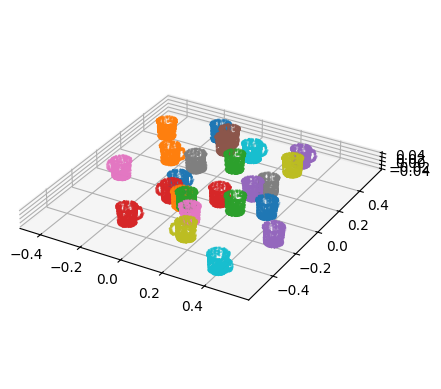

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")


def pose_samples(ax, key, pose_gf, pose_span, n_samples):
    keys = jax.random.split(key, n_samples)
    poses = (pose_gf.simulate(k, pose_span).get_retval() for k in keys)
    for P in poses:
        # We use [::16] as a cheap way to "downsample" the cup model, which speeds up the figure generation
        viz_model(ax, cup4[::16], P)
    ax.set_aspect("equal")


key, sub_key = jax.random.split(key)
pose_samples(ax, sub_key, pose_gf, tabletop_pose_span, 25)

As you can see, this is a plausible distribution of tabletop cup poses. In the next section, we will introduce a photograph containing this object and use Gen to compute its location given the visual evidence of its pose.

# Pose Inference

The first task will be to load a real scene image coupled with a depth layer, which we will call `rgbd`. The cup on the table will look familiar at this point: it's the object that was scanned to produce the model we have been using above.

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)


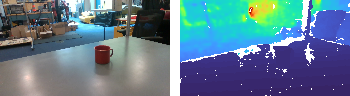

In [16]:
with open("./tutorial_mug_image.pkl", "rb") as file:
    data = pickle.load(file)[0]
K = data["camera_image"]["camera_matrix"][0]
rgb = data["camera_image"]["rgbPixels"]
depth = data["camera_image"]["depthPixels"]
camera_pose = b.t3d.pybullet_pose_to_transform(data["camera_image"]["camera_pose"])
fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
h, w = depth.shape
rgbd_original = b.RGBD(
    rgb, depth, camera_pose, b.Intrinsics(h, w, fx, fy, cx, cy, near=0.001, far=1.0)
)
rgbd = b.RGBD.scale_rgbd(rgbd_original, scaling_factor=0.2)


# Change the depth camera pose to the one used in the source image
def setup_renderer(bop_mesh_indices, intrinsics=None, scaling_factor=1e-3):
    intrinsics = intrinsics or b.Intrinsics(
        height=100, width=100, fx=150.0, fy=150.0, cx=50.0, cy=50.0, near=0.001, far=6.0
    )
    assets = pathlib.Path(bu.get_assets_dir())
    b.setup_renderer(intrinsics)
    for index in bop_mesh_indices:
        b.RENDERER.add_mesh_from_file(
            assets / f"bop/ycbv/models/obj_{index+1:06}.ply",
            scaling_factor=scaling_factor,
        )


setup_renderer([13], rgbd.intrinsics)
b.hstack_images([b.get_rgb_image(rgbd.rgb), b.get_depth_image(rgbd.depth)])

The next step will be adapting our cup pose generator to the scene. We want to transform our cup model into the scene respecting the perspective of the image. We can learn about the image perspective by finding the camera pose that would render the rectangular tabletop as it is seen in the sample image. Bayes3D provides a utility for this: `infer_table_plane`. 

Briefly: we "unproject" the image (which means combining the RGB and depth components of our source image by moving the pixels backward into the view volume. The result is a 3D point cloud which, if projected back onto the view plane, would reconstruct the original flat image). From that point cloud, points are clustered and segmented for co-planarity. Then it will figure out the `table_pose`. 

In [17]:
obs_img = b.unproject_depth_jit(rgbd.depth, rgbd.intrinsics)
table_pose, plane_dims = bu.infer_table_plane(
    obs_img,
    jnp.eye(4),
    rgbd.intrinsics,
    ransac_threshold=0.001,
    inlier_threshold=0.001,
    segmentation_threshold=0.1,
)

In [18]:
table_pose

Array([[-0.05665741,  0.99560744, -0.05274212,  0.05176784],
       [ 0.34602126, -0.02983841, -0.93757266,  0.06900166],
       [-0.9350281 , -0.07137033, -0.34376705,  0.7438539 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)

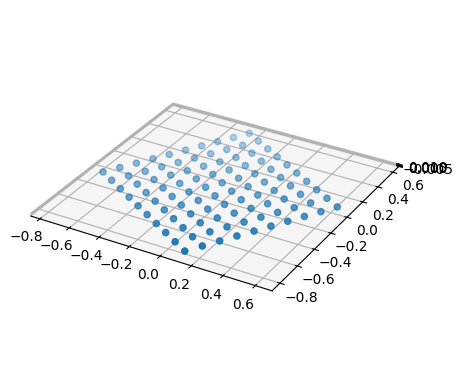

In [19]:
def viz_table(pose, ax):
    xyzs = jnp.array(
        [
            [x, y, 0.0, 1.0]
            for x in jnp.linspace(0.0, 1.0, 10)
            for y in jnp.linspace(0.0, 1.0, 10)
        ]
    )
    points = pose @ xyzs.T
    ax.scatter3D(points[0], points[1], points[2])
    ax.set_aspect("equal")


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
viz_table(rgbd.camera_pose @ table_pose, ax)

The table is lying more or less flat in the $x, y$ plane and is rotated a bit, just as we observe in the image.

## What does Bayes3D provide to help with the inference?

Bayes3D contains a custom GPU-accelerated rendering function that acts like a virtual _depth camera_. Rather than produce an RGB color image with lighting, shadows, and other visual effects, the Bayes3D renderer produces a depth map. Just as in the polynomial evaluation demo for GenJAX, we will use a ChoiceMap to fix the ground truth, and let the _model parameters_ vary. Bayes3D will draw samples from the pose distribution, compute depth images, and then compare those images to the depth image of the ground truth to determine the _likelihood_ that the sampled model parameters could explain the depth image we have supplied. Using the GPU acceleration in JAX, we can do thousands of such comparisons in parallel. Each such comparison results in a log-likelihood score.

The first step in this process will be to produce a generative function which explores the possible positions of the cup in the scene and renders a depth map of the cup. Our pose generative function above was more general than we need. For a tabletop pose, assuming the cup is sitting upright and flat on the table, all we need are three parameters: an $x, y$ position for the cup base and an rotation angle $\alpha$. The Bayes3D library has support for working with such _contact parameters_ represented as the `jnp` array $[x, y, \alpha]$. We'll create a function that turns this data into a pose matrix.

In [20]:
def pose_from_contact(contact):
    x, y, alpha = contact
    R = Rotation.from_euler("z", alpha)
    T = jnp.array([x, y, 0.0])
    return make_pose(R, T)

The resulting `scene_model` draws contact parameters from uniform distributions, creates the corresponding pose matrix, transforms the pose matrix into the table frame using the `table_pose` we learned above, and produces a depth map of the cup in that position.

In [22]:
@genjax.static_gen_fn
def scene_model(table_pose, box_dims):
    contact = (
        genjax.uniform(
            jnp.array([-0.5, -0.5, -10 * jnp.pi]), jnp.array([0.5, 0.5, 10 * jnp.pi])
        )
        @ "contact"
    )
    object_pose = table_pose @ scene_graph.relative_pose_from_edge(contact, 3, box_dims)
    rendered_image = b.RENDERER.render(object_pose[None, ...], jnp.array([0]))[..., :3]
    return rendered_image, contact

Just as we can sample from the generative function representing poses, we can sample from the scene models that Bayes3D can produce from the compact but powerful model above. Here's a 3x3 grid of depth images generated by the model:

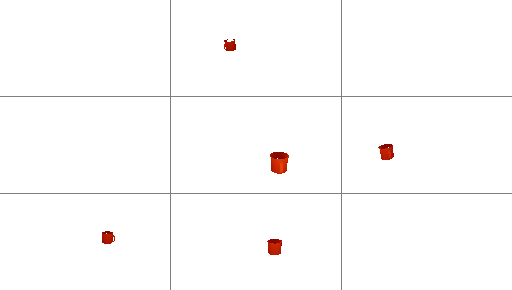

In [23]:
def viz_scene_model(key, nrows=3, ncols=3):
    sub_keys = jax.random.split(key, nrows * ncols)
    scene_model_sim = jax.jit(scene_model.simulate)
    scene_model_args = (table_pose, b.RENDERER.model_box_dims[0])
    return b.hvstack_images(
        [
            b.get_depth_image(scene_model_sim(k, scene_model_args).get_retval()[0])
            for k in sub_keys
        ],
        nrows,
        ncols,
        border=1,
        bg_color=(127, 127, 127),
    )


key, sub_key = jax.random.split(key)
viz_scene_model(sub_key)

Try reevaluating that cell a few times. You should obseve that the cup model is now respecting the perspective of the ambient scene!

The next step is score such a proposed cup position versus what we see in the image. The `PixelLikelihood` function add some noise and outlying points to the model--quite similar to what we did in the notebook inferring a polynomial model for sequence of $x, y$ values--and computes the log-probability of the pixel match. Since there is a two dimensional array of such pixels, we wrap the score function in `map_combinator` _twice_: once for each dimension. Doing this will allow us to execute the inference computation on each pixel in parallel on the GPU. 

In [43]:
class PixelLikelihood(genjax.ExactDensity, genjax.JAXGenerativeFunction):
    def sample(self, key, rendered_xyz, radius, outlier_prob):
        is_outlier = jax.random.uniform(key) < outlier_prob
        # If it's an outlier, we sample from a uniform distribution over a large interval.
        outlier_output = is_outlier * jax.random.uniform(
            key, minval=-100.0, maxval=100.0, shape=rendered_xyz.shape
        )
        # If it's not an outlier, we sample from a uniform distribution over a small interval of length `radius`
        non_outlier_output = rendered_xyz + jax.random.uniform(
            key, minval=-radius / 2, maxval=radius / 2, shape=rendered_xyz.shape
        )
        return outlier_output + non_outlier_output

    def logpdf(self, observed_xyz, rendered_xyz, radius, outlier_prob):
        distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
        probabilities_per_pixel = (1 - outlier_prob) * (
            distances < radius / 2
        ) / radius + outlier_prob
        return jnp.log(probabilities_per_pixel)


pixel_likelihood = PixelLikelihood()


@genjax.map_combinator(in_axes=(0, None, None))
@genjax.map_combinator(in_axes=(0, None, None))
@genjax.static_gen_fn
def likelihood_for_image(rendered_xyz, radius, outlier_prob):
    observed_xyz = pixel_likelihood(rendered_xyz, radius, outlier_prob) @ "observed_xyz"
    return observed_xyz

This generative function is waiting to have rendered images, such as are produced by scene_model, and a noise radius plumbed into it. The last step is to create a generative function which chooses the distribution of the radius parameter and pairs it with rendered images from the scene model to produce the full model.

In [44]:
@genjax.static_gen_fn
def full_model(table_pose, box_dims):
    rendered_image, contact = scene_model(table_pose, box_dims) @ "scene"
    radius = genjax.uniform(0.001, 0.1) @ "radius"
    observed_image = (
        likelihood_for_image(rendered_image, radius, 0.001) @ "observed_image"
    )
    return observed_image, rendered_image, radius, contact

In a way, this isn't that much more complicated than uncovering the model behind a curve. Just as we can draw from distributions of slope and intercept, or polynomial coefficients, to fit a curve, in this model we are drawing samples of a cup depth map from among its plausible positions with a little added noise. We had to do a little linear algebra to get the cup model to appear in the scene in such positions, and develop a scoring model, but at this point, we have the pieces we need to begin the inference task.

To gather some intuition on what we have so far, we can create a visualization...

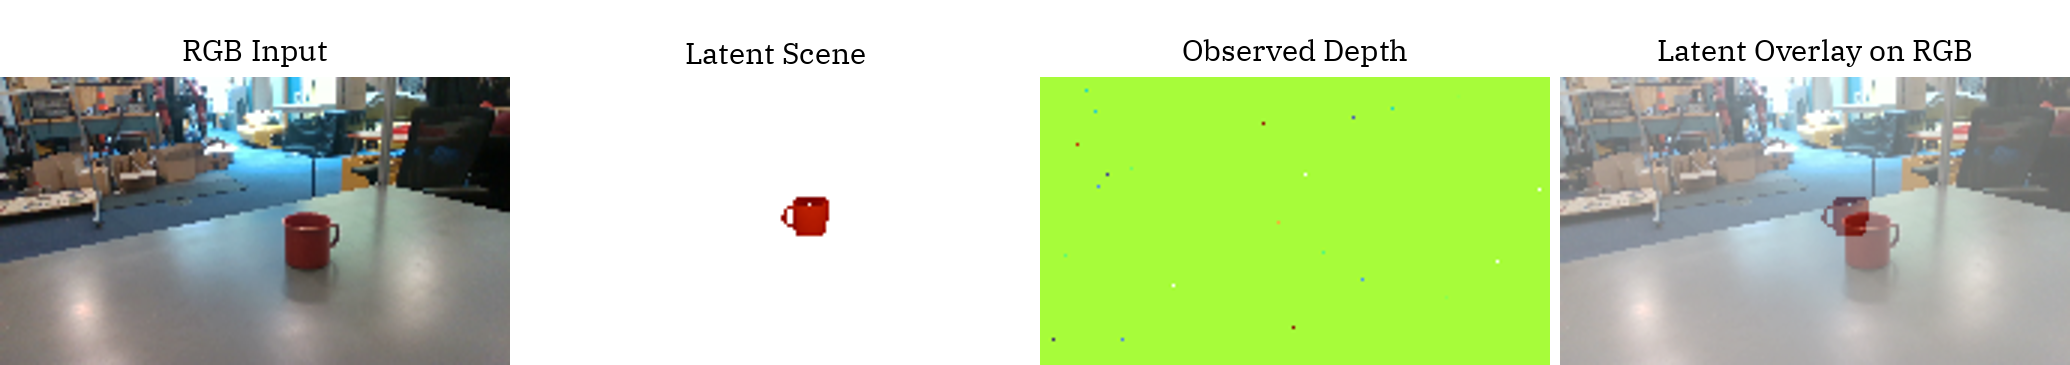

In [45]:
key = jax.random.PRNGKey(2)
trace = full_model.simulate(key, (table_pose, b.RENDERER.model_box_dims[0]))
trace_to_image = lambda trace: b.get_depth_image(trace.get_retval()[1][..., 2])


def viz_trace(rgb, trace):
    bigger = lambda image: b.scale_image(image, 3.0)
    img = bigger(b.get_depth_image(trace.get_retval()[1][..., 2]))
    rgb = bigger(b.get_rgb_image(rgb))
    observed_depth = bigger(b.get_depth_image(trace.get_retval()[0][..., 2]))

    return b.multi_panel(
        [rgb, img, observed_depth, b.overlay_image(rgb, img, alpha=0.4)],
        ["RGB Input", "Latent Scene", "Observed Depth", "Latent Overlay on RGB"],
    )


viz_trace(rgbd.rgb, trace)

In [28]:
rgbd.rgb.shape
genjax.__version__

'0.1.0.post33.dev0+e0896338'

This is the orignal scene, a cup model drawn from the full model, that model with some noise added to the depth, and a comparison of the sampled position with the actual cup position.

Just as in previous notebooks, to run the process backwards, we create a _choice map_ to lock down the observed depth, and allow the inference to explore the space spanned by the other model parameters looking for one which is more likely.

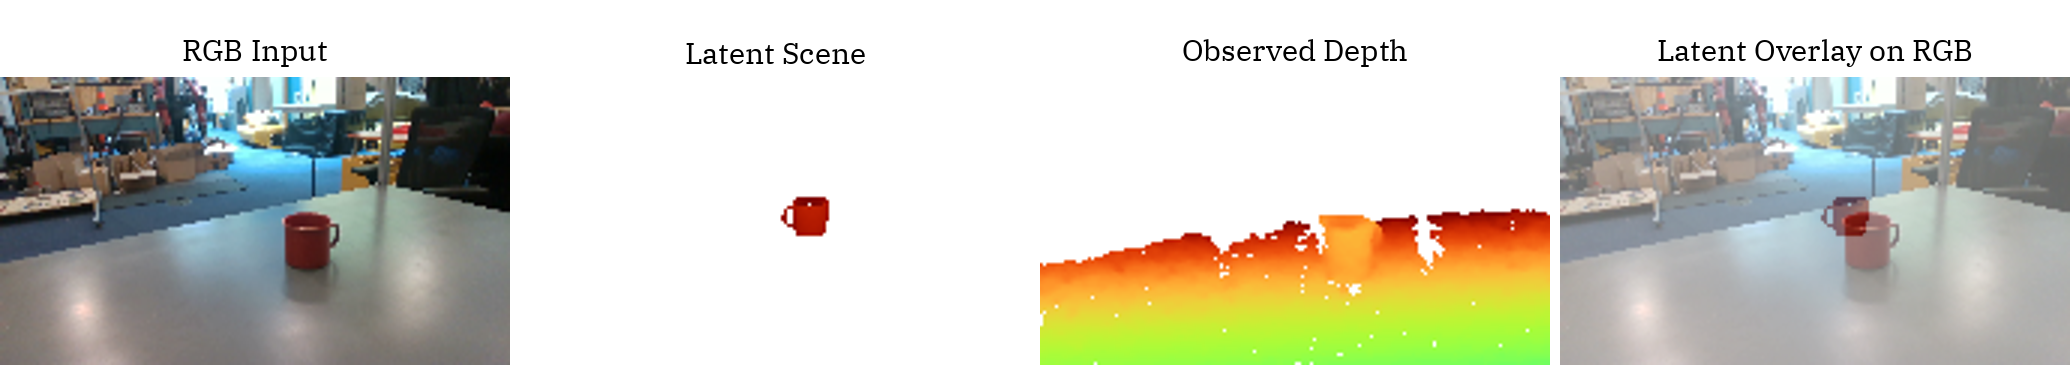

In [46]:
obs_img = b.unproject_depth_jit(rgbd.depth, rgbd.intrinsics)
trace = trace.update(
    key,
    genjax.choice_map(
        {
            "observed_image": genjax.vector_choice_map(
                genjax.vector_choice_map({"observed_xyz": genjax.choice_value(obs_img)})
            )
        }
    ),
    genjax.incremental.tree_diff_no_change(trace.get_args()),
)[0]
viz_trace(rgbd.rgb, trace)

Importance sampling is not going to be strong enough to solve this problem, so instead, we guide the inference using a technique called _Coarse to Fine_. This technique involves starting with a mesh of proposals, finding the most likely candidate among the mesh points, and then restarting inference in the best location seen so far with a finer mesh. 

The meshes above will be meshes of contact parameters $[x, y, \alpha]$, allowing for motion on the table plane and rotation around the cup's $z$ axis. To create a score, we will "paste" the contact parameters into the previous trace and get a score.

One of Gen's mathematical underpinnings is being mathematically fastidious about scoring probabilities based on the likelihoods of each of the decisions (or choices) that has produced a trace. This is coupled with JAX, a system that knows how to execute such functions on the GPU. While the updating of the choice map and score update might look like costly operations, the effort to accomplish all of this has been abstracted away by the JAX compiler, so we will be able to evalate each of the candidate mesh points *and* each of the pixels in the consequential depth image in parallel on the GPU.

This is why we use `jax.jit` and `jax.vmap` on the functions below. `jax.vmap` prepares a function for parallel evaluation and `jax.jit` compiles it into the kind of code that can be run on a GPU.

In [47]:
def update_contact_params_in_trace(trace, cp):
    new_trace = trace.update(
        key,
        genjax.choice_map({"scene": {"contact": cp}}),
        tree_diff_no_change(trace.get_args()),
    )[0]
    return new_trace


def score_new_contact_param(trace, cp):
    return update_contact_params_in_trace(trace, cp).get_score()


score_new_contact_param_vmap = jax.jit(
    jax.vmap(score_new_contact_param, in_axes=(None, 0))
)


def score_new_radius(trace, radius):
    return trace.update(
        key,
        genjax.choice_map({"radius": radius}),
        tree_diff_no_change(trace.get_args()),
    )[0].get_score()


score_new_radius_vmap = jax.jit(jax.vmap(score_new_radius, in_axes=(None, 0)))

`expand_mesh` just takes the "corners" of a mesh and fills in the intermediate contact parameters. The JAX `vmap`ped function will operate on each of these cup contact possibilities in parallel.

In [37]:
def expand_mesh(min_x, max_x, min_y, max_y, min_z, max_z, num_x, num_y, num_z):
    deltas = jnp.stack(
        jnp.meshgrid(
            jnp.linspace(min_x, max_x, num_x),
            jnp.linspace(min_y, max_y, num_y),
            jnp.linspace(min_z, max_z, num_z),
        ),
        axis=-1,
    )
    deltas = deltas.reshape(-1, 3)
    return deltas

Here we have the grid schedule. Each grid has a smaller span and a tighter mesh than the one previous. The angle parameters have a wider span than $[-\pi, \pi]$ to avoid a singularity effect at $\alpha=\pi$, where two points that should be considered close appear widely separated in the math. 

In [48]:
cp_grids = [
    expand_mesh(-0.3, 0.3, -0.3, 0.3, -jnp.pi, jnp.pi, 25, 25, 25),
    expand_mesh(-0.1, 0.1, -0.1, 0.1, -jnp.pi / 2, jnp.pi / 2, 25, 25, 25),
    expand_mesh(-0.05, 0.05, -0.05, 0.05, -jnp.pi / 4, jnp.pi / 4, 25, 25, 25),
    expand_mesh(-0.02, 0.02, -0.02, 0.02, -jnp.pi / 4, jnp.pi / 4, 25, 25, 25),
    expand_mesh(-0.02, 0.02, -0.02, 0.02, -jnp.pi / 8, jnp.pi / 8, 25, 25, 25),
]


def coarse_to_fine(key, cp_grids):
    # compute initial trace
    trace = full_model.simulate(key, (table_pose, b.RENDERER.model_box_dims[0]))
    trace = trace.update(
        key,
        genjax.choice_map(
            {
                "observed_image": genjax.vector_choice_map(
                    genjax.vector_choice_map(
                        {"observed_xyz": genjax.choice_value(obs_img)}
                    )
                )
            }
        ),
        tree_diff_no_change(trace.get_args()),
    )[0]
    traces_at_each_inference_step = [trace_to_image(trace)]

    for cp_grid in cp_grids:
        cp_grid_centered_at_current_cp = cp_grid + trace["scene", "contact"]
        scores = score_new_contact_param_vmap(trace, cp_grid_centered_at_current_cp)
        new_trace = update_contact_params_in_trace(
            trace, cp_grid_centered_at_current_cp[scores.argmax()]
        )
        print(f"[{scores.min()} .. {scores.max()}] -> {new_trace.get_score()}")
        viz_trace(rgbd.rgb, new_trace)
        traces_at_each_inference_step.append(trace_to_image(new_trace))
        trace = new_trace

    return traces_at_each_inference_step


traces_at_each_inference_step = coarse_to_fine(jax.random.PRNGKey(101), cp_grids)

[-inf .. -27607.98828125] -> -27607.98828125
[-30692.484375 .. -27515.63671875] -> -27515.63671875
[-29501.166015625 .. -27404.818359375] -> -27404.81640625
[-28910.125 .. -27395.58203125] -> -27395.58203125
[-28974.771484375 .. -27395.58203125] -> -27395.58203125


6


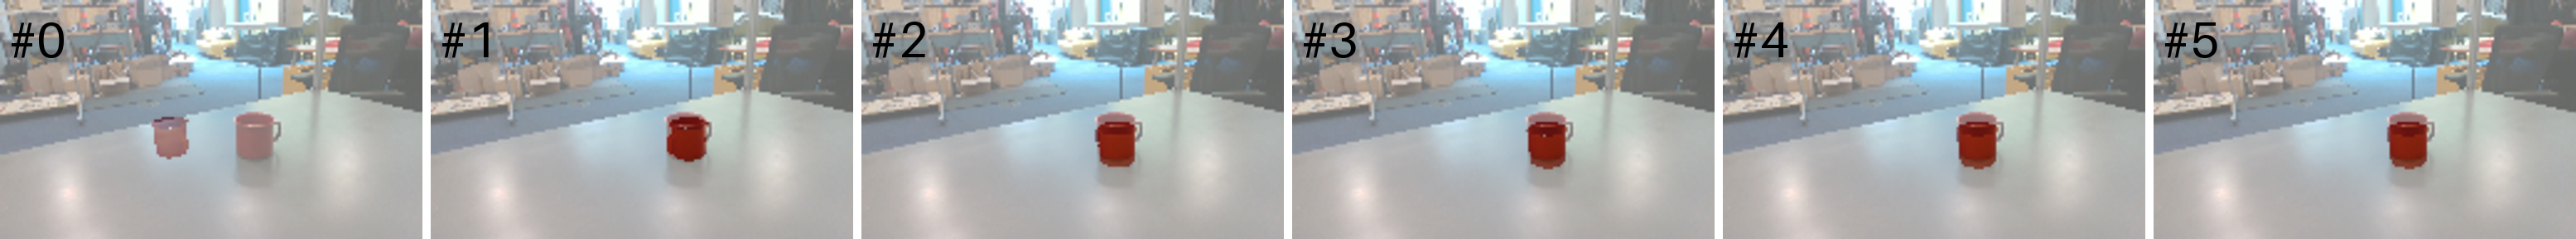

In [49]:
def animate_convergence(ground, traces, anim=False):
    bigger = lambda image: b.scale_image(image, 3.0)

    def make_one_image(i, t):
        img = b.overlay_image(bigger(b.get_rgb_image(ground)), bigger(t), alpha=0.4)
        draw = ImageDraw.Draw(img)
        draw.text((10, 10), f"#{i}", font_size=60, fill=(0, 0, 0))
        return img

    images = list(make_one_image(i, t) for i, t in enumerate(traces))
    if anim:
        name = f"anim-{key[0]}-{key[1]}.gif"
        images[0].save(
            name, append_images=images[1:], optimize=False, duration=1, save_all=True
        )
        return Image.open(name)
    else:
        return b.hstack_images(images)


print(len(traces_at_each_inference_step))
animate_convergence(rgbd.rgb, traces_at_each_inference_step)

Some internal notes:
- The convergence is very fast: the first mesh step gets us 95% of the way there, typically.
- I want to experiement with a less "fixed" schedule: maybe a starting value, and then simply scale each new entry down by 0.5 for example
- Combining those two ideas and a slower "learning rate" for the mesh might make the animation more "fun"
- inference of the handle orientation is not guaranteed
- I haven't dealt with the radius inference stuff because I don't know what to say about it
- Might be interesting to try another BOP object and see if everything "just works," perhaps an exercise for the students

In [50]:
genjax.__version__

'0.1.0.post33.dev0+e0896338'